* we will emphasize language models in this chapter.

* practical techniques for preprocessing text data

* basic concepts of a language model and use this discussion as the inspiration for the design of RNNs.

* the gradient calculation method for RNNs to explore problems that may be encountered when training such networks.

## 8.1 Sequence Models

In [ ]:
pip install d2l==0.17.2

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

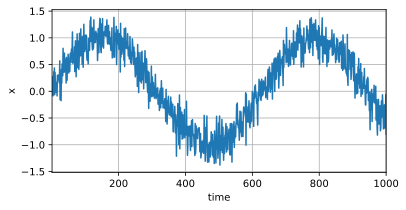

In [3]:
T = 1000 # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype = torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim = [1,1000], figsize = (6, 3))

In [4]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
  features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [5]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [6]:
# MLP with two fully-connected layers, ReLU activation, and squared loss.
# Function for initializing the weights of the network
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
  net = nn.Sequential(nn.Linear(4, 10),
                      nn.ReLU(),
                      nn.Linear(10, 1)
                      )
  net.apply(init_weights)
  return net

# Note : `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction = 'none')

In [7]:
def train(net, train_iter, loss, epochs, lr):
  trainer = torch.optim.Adam(net.parameters(), lr)
  for epoch in range(epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.sum().backward()
      trainer.step()
    print(f'epoch {epoch + 1}, '
          f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [8]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.073961
epoch 2, loss: 0.062846
epoch 3, loss: 0.057675
epoch 4, loss: 0.055598
epoch 5, loss: 0.053872


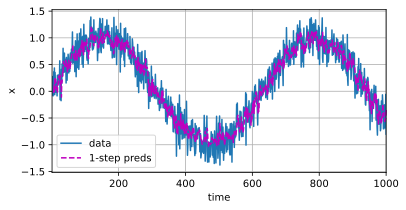

In [9]:
# The first thing to check is how well the model is able to predict what happens just in the next time step, namely the one-step-ahead prediction.
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend = ['data', '1-step preds'], xlim = [1, 1000], figsize = (6, 3))

In [10]:
# we will have to use our own predictions to make multistep-ahead predictions.
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))

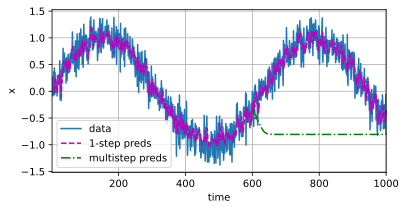

In [11]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
         'time', 'x', legend = ['data', '1-step preds', 'multistep preds'],
         xlim = [1, 1000], figsize = (6, 3)
         )

In [12]:
# Let us take a closer look at the difficulties in k-step-ahead predictions by computing predictions on the entire sequence for k = 1, 4, 16, 64.
max_steps = 64
features = torch.zeros((T-tau-max_steps + 1, tau+max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from `i+1` to `i+T-tau-max_step+1`
for i in range(tau):
  features[:, i] = x[i:i+T-tau-max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for time steps from `i+1` to `i+T-tau-max_steps+1`
for i in range(tau, tau+max_steps):
  features[:, i] = net(features[:, i-tau:i]).reshape(-1)

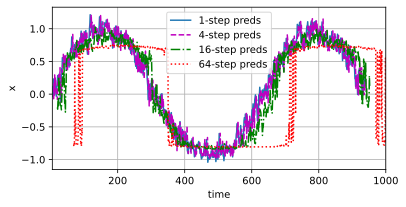

In [13]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau+i-1:T-max_steps +i] for i in steps],
         [features[:, (tau+i-1)].detach().numpy() for i in steps],
         'time', 'x',
         legend = [f'{i}-step preds' for i in steps],
         xlim = [5, 1000],
         figsize = (6, 3)
)

This clearly ilustrates how the quality of the prediction changes as we try to predict further into the future. While the 4-step-ahead predictions still look good, anything beyond that is almost useless.

## Summary
* There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a sequence, always respect the temporal order of the data when training, i.e., never train on future data.

* Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.

* For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.

* For an observed sequence up to time step *t*, its predicted output at time step *t+k* is the *k-step-ahead prediction*. As we predict further in time by increasing *k*, the errors accumulate and the quality of the prediction degrades, often dramatically.

## 8.2 Text Preprocessing

text is one of the most popular examples of sequnece data.

For example, an article can be simply viewed as a sequence of words, or even a sequence of characters. 

**common preprocessing steps for text**

1. Load text as strings into memory.

2. Split strings into tokens (e.g, words and characters)

3. Build a table of vocabulary to map the split tokens to numerical indices.

4. Convert text into sequences of numerical indices so they can be manipulated by models easily.

In [3]:
import collections
import re

In [4]:
# reading the dataset
# here, we ignore punctuation and capitalization

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
  """Load the time machine dataset into a list of text lines."""
  with open(d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [5]:
lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [6]:
# Tokenization
# A token is the basic unit in text.

def tokenize(lines, token = 'word'):
  """Split text lines into word or character tokens."""
  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknown token type: ' + token)

In [7]:
tokens = tokenize(lines)
for i in range(11):
  print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [8]:
# Vocabulary
# Now let us build a dictionary, often called vocabulary as well, to map string tokens into numerical indices starting from 0
# To do so, we first count the unique tokens in all the documents from the training set, namely a corpus, and then assign a numerical index to each unique token according to its frequency.
class Vocab:
  """Vocabulary for text."""
  def __init__(self, tokens = None, min_freq = 0, reserved_tokens = None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse = True)
    # The index for the unknown token is 0
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break
      if token not in self.token_to_idx:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1
  
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]
  
  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    return [self.idx_to_token[index] for index in indices]
  
  @property
  def unk(self): # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self): # Index foro the unknown token
    return self._token_freqs

In [9]:
def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a list of tokens
    tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

In [10]:
# We construct a vocabulary using the time machine dataset as the corpus. Then we print the first few frequent tokens with their indices.
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [11]:
for i in [0, 10]:
  print('words:', tokens[i])
  print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [12]:
# 1) we tokenize text into characters, not words, to simplify the training in later sections
# 2) corpus is a single list, not a list of token lists, since each text line in the time machine dataset is not necessarily a sentence or a paragraph
def load_corpus_time_machine(max_tokens = -1):
  """Return token indices and the vocabulary of the time machine dataset."""
  lines = read_time_machine()
  tokens = tokenize(lines, 'char')
  vocab = Vocab(tokens)
  # Since each text line in the time machine dataset is not necessarily a sentence or a paragraph, flatten all the text lines into a single list
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens]
  return corpus, vocab

In [13]:
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## Summary
* Text is an important form of sequence data.

* To preprocess text, we usually split text into tokens, build a vocabulary to map token strings into numerical indices, and convert text data into token indices for models to manipulate.

In [4]:
import random
import torch

In [5]:
tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

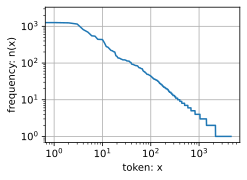

In [6]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel = 'token: x', ylabel = 'frequency: n(x)', xscale = 'log', yscale = 'log')

In [7]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [8]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

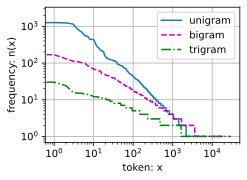

In [9]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel = 'token: x', ylabel='frequency: n(x)', xscale = 'log', yscale = 'log', legend = ['unigram', 'bigram', 'trigram'])

In [12]:
def seq_data_iter_random(corpus, batch_size, num_steps):
  """Generate a minibatch of subsequences using random sampling."""
  # Start with a random effect (inclusive of `num_steps - 1`) to partition a sequence
  corpus = corpus[random.randint(0, num_steps - 1):]
  # Substract 1 since we need to account for labels
  num_subseqs = (len(corpus) - 1) // num_steps
  # The starting indices for subsequences of length `num_steps`
  initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
  # In random sampling, the subsequences from two adjacent random minibatches during iteration are not necessarily adjacent on the original sequence
  random.shuffle(initial_indices)

  def data(pos):
    # Return a sequence of length `num_steps` starting from `pos`
    return corpus[pos: pos+num_steps]
  
  num_batches = num_subseqs // batch_size
  for i in range(0, batch_size * num_batches, batch_size):
    # Here, `initial_indices` contains randomized starting indices for subsequences
    initial_indices_per_batch = initial_indices[i: i+batch_size]
    X = [data(j) for j in initial_indices_per_batch]
    Y = [data(j+1) for j in initial_indices_per_batch]
    yield torch.tensor(X), torch.tensor(Y)


In [13]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size = 2, num_steps = 5):
  print('X: ', X, '\nY: ', Y)

X:  tensor([[25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4]]) 
Y:  tensor([[26, 27, 28, 29, 30],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]) 
Y:  tensor([[11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]])


In [16]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
  """Generate a minibatch of subsequences using sequential partitioning."""
  # Start with a random offset to partition a sequence
  offset = random.randint(0, num_steps)
  num_tokens = ((len(corpus)-offset-1)//batch_size) * batch_size
  Xs = torch.tensor(corpus[offset:offset+num_tokens])
  Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])
  Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
  num_batches = Xs.shape[1] // num_steps
  for i in range(0, num_steps * num_batches, num_steps):
    X = Xs[:, i: i+num_steps]
    Y = Ys[:, i: i+num_steps]
    yield X, Y

In [17]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size = 2, num_steps = 5):
  print('X: ', X, '\nY: ', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [18]:
class SeqDataLoader:
  """An iterator to load sequence data."""
  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
    if use_random_iter:
      self.data_iter_fn = d2l.seq_data_iter_random
    else:
      self.data_iter_fn = d2l.seq_data_iter_sequential
    self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
    self.batch_size, self.num_steps = batch_size, num_steps

  def __iter__(self):
    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [19]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens = 10000):
  """Return the iterator and the vocabulary of the time machine dataset."""
  data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
  return data_iter, data_iter.vocab

## Summary
* Language models are key to natural language processing.

* n-grams provide a convenient model for dealing with long sequences by truncating the dependence.

* Long sequences suffer from the problem that they occur very rarely or never.

* Zipf's law governs the word distribution for not only unigrams but also the other n-grams.

* There is a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via Laplace smoothing.

* The main choices for reading long sequences are random sampling and sequential partitioning. The latter can ensure that the subsequences from two adjacent minibatches during iteration are adjacent on the original sequence.

## 8.4 Recurrent Neural Networks

In [ ]:
import torch
from d2l import torch as d2l

In [20]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-6.9247,  2.5626, -4.4459,  0.8872],
        [ 2.8089, -4.0723,  1.5641,  0.2850],
        [-1.8945,  0.2242,  0.1111,  0.0812]])

In [21]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-6.9247,  2.5626, -4.4459,  0.8872],
        [ 2.8089, -4.0723,  1.5641,  0.2850],
        [-1.8945,  0.2242,  0.1111,  0.0812]])

## Summary
* A neural network that uses recurrent computation for hidden states is called a recurrent neural network(RNN).

* The hidden state of an RNN can capture historical information of the sequence up to the current time step.

* The number of RNN model parameters does not grow as the number of time steps increases.

* We can create character-level language models using an RNN.

* We can use perplexity to evaluate the quality of language models.